In [ ]:
import torch
import torchvision.models as models
from torchsummary import summary


import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
# import torchvision.transforms as transforms
import torchsummary
from tqdm import tqdm

# 将模型移动到 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


# <1> 数据预处理
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor()  ])

dataset_path = r"/mnt/workspace/data/ImageNet-10"
# <2> 加载MNIST数据集
dataset = torchvision.datasets.ImageFolder(root= dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))  # 训练集占80%，1,300张*0.8=1040张
test_size = len(dataset) - train_size # 测试集占20%，1,300张-1040张=260张
torch.manual_seed(42)  # 为了保证每次划分的数据集一致
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=4)


In [ ]:
# 加载预训练的 EfficientNet 模型
efficientnet = models.efficientnet_b0(pretrained=False).to(device)



# 显示网络结构
summary(efficientnet, (3, 224, 224))



In [5]:
# <4> 损失函数
criterion = nn.CrossEntropyLoss()

# <5> 优化器
optimizer = optim.Adam(efficientnet.parameters(), lr=0.0001)

In [6]:
 #<6> 自定义计算准确率函数
def test(model, testloader): 
    # <6-1> 进入评估模式
    model.eval()

    # <6-2> 计算输出
    correct = total = 0
    with torch.no_grad():   # 关闭梯度计算
        # 从测试集中一批一批地取数据, 每批64个, 一共取260/64=4次+1次
        for images, labels in testloader: 

            # 4) 将测试数据加载到GPU上
            images, labels = images.to(device), labels.to(device)

            # 计算预测值
            outputs = model(images)

            # <6-3> 计算准确率
            # 按行(=1)取最大值，返回最大值、最大值的索引(预测结果)
            _, predicted = torch.max(outputs.data, 1)

            # 预测值与真实值比较后, 再求和
            correct += (predicted == labels).sum().item()
            # 测试集总数
            total += labels.size(0)

    # 准确率
    accuracy = correct / total

    # 返回：准确率
    return accuracy

In [7]:
# <7> 训练模型
# 初始化训练过程中的指标：训练精度、测试精度、损失，用于绘图
train_acc_history, test_acc_history, loss_history = [], [], []

for epoch in tqdm(range(10)):  # 训练10个epoch
    efficientnet.train()
    epoch_loss = 0.0        # 每epoch的损失
    running_loss = 0.0      # 每64批次batch的损失

    # 从0开始计数，每次取一个batch，一共取1040/64=16.25次
    for i, data in enumerate(trainloader, 0):
        X_train, y_train = data

        # 3) 将训练数据加载到GPU上
        X_train, y_train = X_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        outputs = efficientnet(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        running_loss += loss.item()

        # 每100个batch打印一次损失
        if i % 100 == 99:  
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.8f}")
            running_loss = 0.0

    # 更新绘图指标
    train_acc_history.append(test(efficientnet, trainloader))
    test_acc_history.append(test(efficientnet, testloader))
    loss_history.append(epoch_loss / len(trainloader))
    print(f"Epoch {epoch + 1} loss: {epoch_loss / len(trainloader):.8f}, train accuracy: {train_acc_history[-1]:.3%}, test accuracy: {test_acc_history[-1]:.3%}")

# 清空CUDA缓存
torch.cuda.empty_cache()

# 打印CUDA内存使用情况
print(f"CUDA memory allocated: {torch.cuda.memory_allocated(device) / 1024**2:.0f} MB")

print("Finished Training")

 60%|██████    | 6/10 [03:58<02:38, 39.70s/it]

Epoch 6 loss: 0.75128619, train accuracy: 86.582%, test accuracy: 71.791%
[Epoch 7, Batch 100] loss: 0.64313049


 70%|███████   | 7/10 [04:38<01:59, 39.75s/it]

Epoch 7 loss: 0.64608555, train accuracy: 88.428%, test accuracy: 69.869%
[Epoch 8, Batch 100] loss: 0.52844875


 80%|████████  | 8/10 [05:18<01:19, 39.64s/it]

Epoch 8 loss: 0.54560331, train accuracy: 91.273%, test accuracy: 70.523%
[Epoch 9, Batch 100] loss: 0.46546112


 90%|█████████ | 9/10 [05:57<00:39, 39.63s/it]

Epoch 9 loss: 0.47830104, train accuracy: 93.877%, test accuracy: 71.791%
[Epoch 10, Batch 100] loss: 0.43521362


100%|██████████| 10/10 [06:37<00:00, 39.71s/it]

Epoch 10 loss: 0.43209424, train accuracy: 94.983%, test accuracy: 71.022%
CUDA memory allocated: 120 MB
Finished Training


findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
findfont: Font family 'simHei' not found.
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Gly

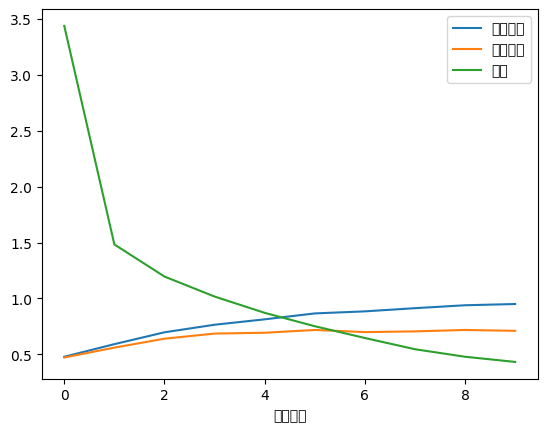

最终训练精度: 94.98%
最终测试精度: 71.02%


In [8]:
# <8> 绘制训练过程中的指标
import matplotlib.pyplot as plt
from matplotlib import rcParams  # 设置全局参数，为了设置中文字体


# 定义绘制函数
def draw_plot(train_acc_history, test_acc_history, loss_history):
    rcParams["font.family"] = "simHei"  # 设置中文黑体字
    plt.figure()
    plt.plot(train_acc_history, label="训练精度")
    plt.plot(test_acc_history, label="测试精度")
    plt.plot(loss_history, label="损失")
    plt.legend()  # 显示图例
    plt.xlabel("迭代次数")
    plt.show()


draw_plot(train_acc_history, test_acc_history, loss_history)
print(f"最终训练精度: {train_acc_history[-1]:.2%}")
print(f"最终测试精度: {test_acc_history[-1]:.2%}")